In [ ]:
!pip install -q transformers torch accelerate bitsandbytes datasets

import json
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
from tqdm import tqdm


In [ ]:
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.3"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token_id = tokenizer.eos_token_id

print("Loading model... (This takes a minute)")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto"
)
print("Model loaded successfully!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading model... (This takes a minute)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Model loaded successfully!


In [ ]:
# Load Source Data (TriviaQA) - keeping it small for the test
print("Loading Source Data (TriviaQA)...")
# We use validation set, first 1000 examples for the test run
trivia_qa = load_dataset("trivia_qa", "rc.nocontext", split="validation[:1000]")

wack_data = []

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Generating WACK Dataset...")
for row in tqdm(trivia_qa):
    question = row['question']
    answer = row['answer']['value']

    # does the model get it right 3 times (reduced from 5 for speed in this test)?
    known = True
    prompt = f"Question: {question}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    for _ in range(3):
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=10,
                temperature=0.5,
                do_sample=True,
                pad_token_id=tokenizer.eos_token_id
            )
        gen_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Simple string matching
        if answer.lower() not in gen_text.lower():
            known = False
            break

    bad_context = """
    Q: What is the capital of France? A: Berlin
    Q: Who wrote Romeo and Juliet? A: Jane Austen
    """
    snowball_prompt = bad_context + f"\nQ: {question}\nA:"
    sb_inputs = tokenizer(snowball_prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        sb_outputs = model.generate(
            **sb_inputs,
            max_new_tokens=10,
            pad_token_id=tokenizer.eos_token_id
        )
    sb_ans = tokenizer.decode(sb_outputs[0], skip_special_tokens=True)

    # 3. Assign Label
    # Logic:
    # - If it didn't know the answer initially -> HK-
    # - If it knew it, but got it wrong now -> HK+
    # - If it knew it, and still got it right -> Correct

    if not known:
        label = "HK-"
    else:
        # Check if the snowball answer is correct
        generated_only = sb_ans.replace(snowball_prompt, "")
        if answer.lower() not in generated_only.lower():
            label = "HK+"
        else:
            label = "Factually Correct"

    # 4. Save
    wack_data.append({
        "question": question,
        "prompt": snowball_prompt,
        "generated_answer": sb_ans, # Real model output for ALL classes
        "label": label
    })

# Save the dataset
with open("wack_dataset.json", "w") as f:
    json.dump(wack_data, f)

print(f"Generated {len(wack_data)} WACK examples. Saved to 'wack_dataset.json'.")

Loading Source Data (TriviaQA)...


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

rc.nocontext/train-00000-of-00001.parque(…):   0%|          | 0.00/55.4M [00:00<?, ?B/s]

rc.nocontext/validation-00000-of-00001.p(…):   0%|          | 0.00/7.34M [00:00<?, ?B/s]

rc.nocontext/test-00000-of-00001.parquet:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/138384 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/17944 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/17210 [00:00<?, ? examples/s]

Generating WACK Dataset...


100%|██████████| 1000/1000 [41:12<00:00,  2.47s/it]

Generated 1000 WACK examples. Saved to 'wack_dataset.json'.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Loading dataset...
Extracting features...


100%|██████████| 1000/1000 [04:21<00:00,  3.82it/s]


--- Balancing Dataset ---
Counts: Correct=370, HK+=120, HK-=510
Downsampling to 120 samples per class...
Training probes...


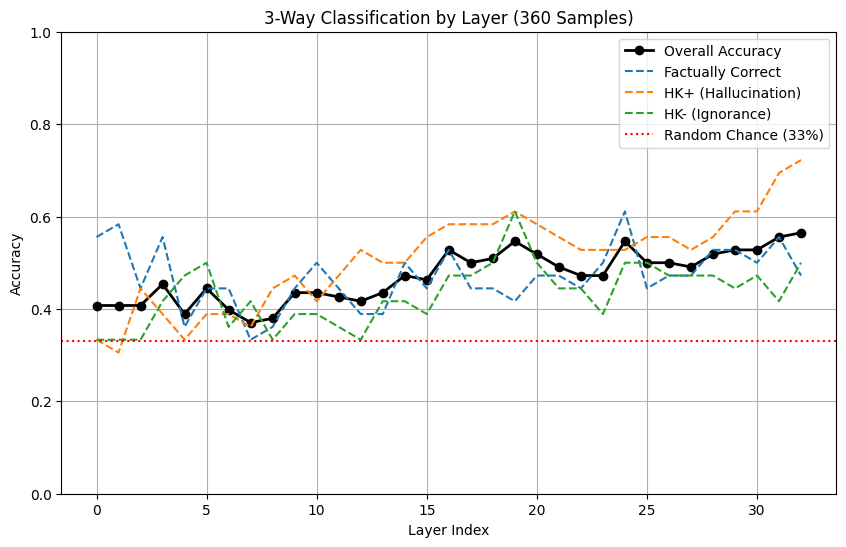

Peak Accuracy: 0.5648148148148148


In [ ]:
# 1. Load Data
print("Loading dataset...")
with open("wack_dataset.json", "r") as f:
    dataset = json.load(f)

if len(dataset) == 0:
    raise ValueError("Dataset is empty!")

# 2. Extract Features (Hidden States)
def extract_hidden_states(model, tokenizer, text_input):
    inputs = tokenizer(text_input, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    extracted_layers = []
    # Grab the last token from each layer
    for layer_tensor in outputs.hidden_states:
        vector = layer_tensor[0, -1, :].float().cpu().numpy()
        extracted_layers.append(vector)
    return np.array(extracted_layers)

print("Extracting features...")
X_all_layers = []
y_labels = []

# Filter and Label
for example in tqdm(dataset):
    # Only process if we have a valid label
    if example['label'] not in ["Factually Correct", "HK+", "HK-"]:
        continue

    full_text = example['prompt'] + example['generated_answer']
    layers_data = extract_hidden_states(model, tokenizer, full_text)

    X_all_layers.append(layers_data)

    if example['label'] == "Factually Correct":
        y_labels.append(0)
    elif example['label'] == "HK+":
        y_labels.append(1)
    elif example['label'] == "HK-":
        y_labels.append(2)

X_all_layers = np.array(X_all_layers)
y_labels = np.array(y_labels)

# 3. Balance Dataset (3 Classes)
print("--- Balancing Dataset ---")
idx_0 = np.where(y_labels == 0)[0]
idx_1 = np.where(y_labels == 1)[0]
idx_2 = np.where(y_labels == 2)[0]

min_len = min(len(idx_0), len(idx_1), len(idx_2))
print(f"Counts: Correct={len(idx_0)}, HK+={len(idx_1)}, HK-={len(idx_2)}")

if min_len == 0:
    raise ValueError("One of the classes has 0 samples! Cannot balance.")

print(f"Downsampling to {min_len} samples per class...")

idx_0_down = np.random.choice(idx_0, min_len, replace=False)
idx_1_down = np.random.choice(idx_1, min_len, replace=False)
idx_2_down = np.random.choice(idx_2, min_len, replace=False)

balanced_indices = np.concatenate([idx_0_down, idx_1_down, idx_2_down])
np.random.shuffle(balanced_indices)

X_balanced = X_all_layers[balanced_indices]
y_balanced = y_labels[balanced_indices]

# 4. Train & Evaluate
accuracies = []
# --- FIX 1: Initialize these lists ---
list_correct = []
list_hk_plus = []
list_hk_minus = []

num_layers = X_balanced.shape[1]
indices = np.arange(len(y_balanced))

train_idx, test_idx, y_train, y_test = train_test_split(
    indices, y_balanced, test_size=0.3, random_state=42, stratify=y_balanced
)

print("Training probes...")
for layer_i in range(num_layers):
    X_layer = X_balanced[:, layer_i, :]
    X_train = X_layer[train_idx]
    X_test = X_layer[test_idx]

    scaler = StandardScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)

    clf = LinearSVC(max_iter=1_000_000, tol=1e-5, random_state=42, dual="auto")
    clf.fit(X_train_norm, y_train)

    preds = clf.predict(X_test_norm)

    # Overall Accuracy
    accuracies.append(accuracy_score(y_test, preds))

    # Per-Class Accuracy
    # We use a safe division or check if the class exists in y_test
    acc_correct = accuracy_score(y_test[y_test==0], preds[y_test==0])
    acc_hk_plus = accuracy_score(y_test[y_test==1], preds[y_test==1])
    acc_hk_minus = accuracy_score(y_test[y_test==2], preds[y_test==2])

    list_correct.append(acc_correct)
    list_hk_plus.append(acc_hk_plus)
    list_hk_minus.append(acc_hk_minus)

# 5. Plot
plt.figure(figsize=(10, 6))
# --- FIX 2: Use range(num_layers) instead of undefined 'layers' ---
x_axis = range(num_layers)

plt.plot(x_axis, accuracies, marker='o', linewidth=2, color='black', label='Overall Accuracy')
plt.plot(x_axis, list_correct, linestyle='--', label='Factually Correct')
plt.plot(x_axis, list_hk_plus, linestyle='--', label='HK+ (Hallucination)')
plt.plot(x_axis, list_hk_minus, linestyle='--', label='HK- (Ignorance)')

plt.axhline(y=0.33, color='r', linestyle=':', label='Random Chance (33%)')

plt.title(f"3-Way Classification by Layer ({len(y_balanced)} Samples)")
plt.xlabel("Layer Index")
plt.ylabel("Accuracy")
plt.ylim(0.0, 1.0)
plt.legend()
plt.grid(True)
plt.show()

print("Peak Accuracy:", max(accuracies))